In [12]:
import astroplan
from astropy.coordinates import ICRS, SkyCoord, AltAz, get_moon, EarthLocation, get_body
from astropy import units as u
from astropy.utils.data import download_file
from astropy.table import Table, QTable, join
from astropy.time import Time, TimeDelta
from astropy_healpix import *
from ligo.skymap import plot
from ligo.skymap.io import read_sky_map
import healpy as hp
import os
from matplotlib import pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import datetime as dt
import pickle
import pandas as pd
from docplex.mp.model import Model

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
warnings.simplefilter('ignore', astroplan.TargetNeverUpWarning)
warnings.simplefilter('ignore', astroplan.TargetAlwaysUpWarning)

In [13]:
directory_path = "/u/ywagh/test_skymaps/"
filelist = sorted([f for f in os.listdir(directory_path) if f.endswith('.gz')])

In [14]:
slew_speed = 2.5 * u.deg / u.s
slew_accel = 0.4 * u.deg / u.s**2
readout = 8.2 * u.s

In [15]:
ns_nchips = 4
ew_nchips = 4
ns_npix = 6144
ew_npix = 6160
plate_scale = 1.01 * u.arcsec
ns_chip_gap = 0.205 * u.deg
ew_chip_gap = 0.140 * u.deg

ns_total = ns_nchips * ns_npix * plate_scale + (ns_nchips - 1) * ns_chip_gap
ew_total = ew_nchips * ew_npix * plate_scale + (ew_nchips - 1) * ew_chip_gap

rcid = np.arange(64)

chipid, rc_in_chip_id = np.divmod(rcid, 4)
ns_chip_index, ew_chip_index = np.divmod(chipid, ew_nchips)
ns_rc_in_chip_index = np.where(rc_in_chip_id <= 1, 1, 0)
ew_rc_in_chip_index = np.where((rc_in_chip_id == 0) | (rc_in_chip_id == 3), 0, 1)

ew_offsets = ew_chip_gap * (ew_chip_index - (ew_nchips - 1) / 2) + ew_npix * plate_scale * (ew_chip_index - ew_nchips / 2) + 0.5 * ew_rc_in_chip_index * plate_scale * ew_npix
ns_offsets = ns_chip_gap * (ns_chip_index - (ns_nchips - 1) / 2) + ns_npix * plate_scale * (ns_chip_index - ns_nchips / 2) + 0.5 * ns_rc_in_chip_index * plate_scale * ns_npix

ew_ccd_corners = 0.5 * plate_scale * np.asarray([ew_npix, 0, 0, ew_npix])
ns_ccd_corners = 0.5 * plate_scale * np.asarray([ns_npix, ns_npix, 0, 0])

ew_vertices = ew_offsets[:, np.newaxis] + ew_ccd_corners[np.newaxis, :]
ns_vertices = ns_offsets[:, np.newaxis] + ns_ccd_corners[np.newaxis, :]

def get_footprint(center):
    return SkyCoord(
        ew_vertices, ns_vertices,
        frame=center[..., np.newaxis, np.newaxis].skyoffset_frame()
    ).icrs

url = 'https://github.com/ZwickyTransientFacility/ztf_information/raw/master/field_grid/ZTF_Fields.txt'
filename = download_file(url)
field_grid = QTable(np.recfromtxt(filename, comments='%', usecols=range(3), names=['field_id', 'ra', 'dec']))
field_grid['coord'] = SkyCoord(field_grid.columns.pop('ra') * u.deg, field_grid.columns.pop('dec') * u.deg)
field_grid = field_grid[0:881]   #working only with primary fields

In [16]:
#******************************************************************************
skymap, metadata = read_sky_map(os.path.join(directory_path, filelist[7]))

plot_filename = os.path.basename(filelist[7])
#******************************************************************************

In [17]:
event_time = Time(metadata['gps_time'], format='gps').utc
event_time.format = 'iso'
print('event time:',event_time)
observer = astroplan.Observer.at_site('Palomar')
night_horizon = -18 * u.deg
if observer.is_night(event_time, horizon=night_horizon):
    start_time = event_time
else:
    start_time = observer.sun_set_time(
        event_time, horizon=night_horizon, which='next')

# Find the latest possible end time of observations: the time of sunrise.
end_time = observer.sun_rise_time(
    start_time, horizon=night_horizon, which='next')

min_airmass = 2.5 * u.dimensionless_unscaled
airmass_horizon = (90 * u.deg - np.arccos(1 / min_airmass))
targets = field_grid['coord']

# Find the time that each field rises and sets above an airmass of 2.5.
target_start_time = Time(np.where(
    observer.target_is_up(start_time, targets, horizon=airmass_horizon),
    start_time,
    observer.target_rise_time(start_time, targets, which='next', horizon=airmass_horizon)))
target_start_time.format = 'iso'

# Find the time that each field sets below the airmass limit. If the target
# is always up (i.e., it's circumpolar) or if it sets after surnsise,
# then set the end time to sunrise.
target_end_time = observer.target_set_time(
    target_start_time, targets, which='next', horizon=airmass_horizon)
target_end_time[
    (target_end_time.mask & ~target_start_time.mask) | (target_end_time > end_time)
] = end_time
target_end_time.format = 'iso'
# Select fields that are observable for long enough for at least one exposure
# sequence of 1800 second.
exposure_time = 300 * u.second
field_grid['start_time'] = target_start_time
field_grid['end_time'] = target_end_time
observable_fields = field_grid[target_end_time - target_start_time >= exposure_time]

# print(observable_fields)
hpx = HEALPix(nside=256, frame=ICRS())

footprint = np.moveaxis(
    get_footprint(SkyCoord(0 * u.deg, 0 * u.deg)).cartesian.xyz.value, 0, -1)
footprint_healpix = np.unique(np.concatenate(
    [hp.query_polygon(hpx.nside, v, nest=(hpx.order == 'nested')) for v in footprint]))

'''
# computing the footprints of every ZTF field as HEALPix indices. Downsampling skymap to same resolution.
'''
footprints = np.moveaxis(get_footprint(observable_fields['coord']).cartesian.xyz.value, 0, -1)
footprints_healpix = [
    np.unique(np.concatenate([hp.query_polygon(hpx.nside, v) for v in footprint]))
    for footprint in tqdm(footprints)]

prob = hp.ud_grade(skymap, hpx.nside, power=-2)

# k = max number of 300s exposures 
min_start = min(observable_fields['start_time'])
max_end =max(observable_fields['end_time'])
min_start.format = 'jd'
max_end.format = 'jd'
k = int(np.floor((max_end - min_start)/(2*exposure_time.to(u.day))))
print(k," number of exposures could be taken tonight")

print("problem setup completed")

event time: 2019-12-12 08:27:28.643


/u/ywagh/.local/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


  0%|          | 0/393 [00:00<?, ?it/s]

28  number of exposures could be taken tonight
problem setup completed


## Model one

In [18]:
m1 = Model('max coverage problem')

field_vars = m1.binary_var_list(len(footprints), name='field')
pixel_vars = m1.binary_var_list(hpx.npix, name='pixel')

footprints_healpix_inverse = [[] for _ in range(hpx.npix)]

for field, pixels in enumerate(footprints_healpix):
    for pixel in pixels:
        footprints_healpix_inverse[pixel].append(field)

for i_pixel, i_fields in enumerate(footprints_healpix_inverse):
     m1.add_constraint(m1.sum(field_vars[i] for i in i_fields) >= pixel_vars[i_pixel])

m1.add_constraint(m1.sum(field_vars) <= k)
m1.maximize(m1.dot(pixel_vars, prob))
print("number fo fields observed should be less than k")

solution = m1.solve(log_output=True)

print("optimization completed")
total_prob_covered = solution.objective_value

print("Total probability covered:",total_prob_covered)


number fo fields observed should be less than k
Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Found incumbent of value 0.000000 after 0.02 sec. (24.20 ticks)
Tried aggregator 3 times.
MIP Presolve eliminated 785920 rows and 728657 columns.
Aggregator did 98 substitutions.
Reduced MIP has 415 rows, 512 columns, and 1596 nonzeros.
Reduced MIP has 512 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.56 sec. (694.63 ticks)
Probing time = 0.00 sec. (0.11 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 415 rows, 512 columns, and 1596 nonzeros.
Reduced MIP has 512 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.10 ticks)
Probing time = 0.00 sec. (0.11 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 32 threads.
Root relaxation solution time = 0.00 sec. (0.62 ticks)

        Nodes   

In [19]:
selected_fields_ID = [i for i, v in enumerate(field_vars) if v.solution_value == 1]

selected_fields = observable_fields[selected_fields_ID]


separation_matrix = selected_fields['coord'][:,np.newaxis].separation(selected_fields['coord'][np.newaxis,:])

def slew_time(separation):
   return np.where(
       separation <= (slew_speed**2 / slew_accel), 
       np.sqrt(2 * separation / slew_accel), 
       (2 * slew_speed / slew_accel) + (separation - slew_speed**2 / slew_accel) / slew_speed
       )

slew_times = slew_time(separation_matrix).value

# slew_time_max = np.max(slew_times) * u.second
# slew_time_max_ = slew_time_max.to_value(u.day) #test

## model two

In [20]:
m2 = Model("Telescope timings")

observer_location = EarthLocation.of_site('Palomar')

# def get_moon_position(time):
#     return get_moon(time, location=observer_location)

#calculate the probability for all the selected fields
footprints_selected = np.moveaxis(get_footprint(selected_fields['coord']).cartesian.xyz.value, 0, -1)
footprints_healpix_selected = [
    np.unique(np.concatenate([hp.query_polygon(hpx.nside, v) for v in footprint]))
    for footprint in tqdm(footprints_selected)]

probabilities = []

for field_index in range(len(footprints_healpix_selected)):
    probability_field = np.sum(prob[footprints_healpix_selected[field_index]])
    probabilities.append(probability_field)
print("worked for",len(probabilities),"fields")

selected_fields['probabilities'] = probabilities

delta = exposure_time.to_value(u.day)
M = (selected_fields['end_time'].max() - selected_fields['start_time'].min()).to_value(u.day).item()
M = M * 20
# moon_proximity = m2.binary_var_list(len(selected_fields), name='selected field')
x = m2.binary_var_list(len(selected_fields), name='selected field')
s = [[m2.binary_var(name=f's_{i}_{j}') for j in range(i)] for i in range(len(selected_fields))]

tc = [m2.continuous_var(
        lb=(row['start_time'] - start_time).to_value(u.day),
        ub=(row['end_time'] - start_time - exposure_time).to_value(u.day),
        name=f'start_times_{i}'
     ) for i, row in enumerate(selected_fields)]

slew_time_value = slew_times*u.second
slew_time_day = slew_time_value.to_value(u.day)

w = 0.1 #wight factor for slew time minimization
        
for i in range(len(tc)):
    for j in range(i):
        m2.add_constraint(tc[i] + delta * x[i] + slew_time_day[i][j] - tc[j] <= M * (1 - s[i][j]),
                          ctname=f'non_overlap_gap_1_{i}_{j}')
        m2.add_constraint(tc[j] + delta * x[j] + slew_time_day[i][j] - tc[i] <= M * s[i][j], 
                          ctname=f'non_overlap_gap_2_{i}_{j}')

#moon distance constraint

m2.maximize(m2.sum(probabilities[i] * x[i] for i in range(len(selected_fields))))

# m2.maximize(m2.sum(x[i] for i in range(len(selected_fields))))

# m2.maximize(m2.sum(probabilities[i] * x[i] for i in range(len(selected_fields))) 
#     - w * m2.sum(slew_times[i][j] * s[i][j] for i in range(len(selected_fields)) for j in range(i)))

# m2.maximize(m2.sum(probabilities[i]*x[i] - w*slew_times[i][j]*s[i][j]*x[i] for i in range(len(selected_fields) for j in range(i))))
# m2.maximize(m2.sum(probabilities[i] * x[i] - w * slew_times[i][j] * s[i][j] * x[i] for i in range(len(selected_fields)) for j in range(i)))

m2.parameters.timelimit = 60
solution = m2.solve(log_output=True)
print("Optimization completed")

  0%|          | 0/28 [00:00<?, ?it/s]

worked for 28 fields
Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
CPXPARAM_TimeLimit                               60
Tried aggregator 1 time.
MIP Presolve modified 1134 coefficients.
Reduced MIP has 756 rows, 434 columns, and 3024 nonzeros.
Reduced MIP has 406 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.32 ticks)
Found incumbent of value 0.000000 after 0.00 sec. (1.97 ticks)
Probing time = 0.00 sec. (1.51 ticks)
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve modified 28 coefficients.
Reduced MIP has 756 rows, 434 columns, and 3024 nonzeros.
Reduced MIP has 406 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.59 ticks)
Probing time = 0.00 sec. (1.51 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 32 threads.
Root relaxation solution time = 0.01 sec. (9.28 ticks)

    

##################The Number of Fields Scheduled:  28 #####################


/u/ywagh/.local/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 28 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/u/ywagh/.local/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 28 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)


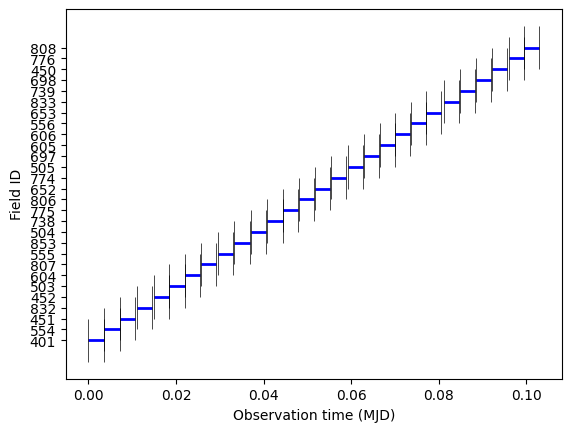

In [23]:
scheduled_start_times = [solution.get_value(var) for var in tc]
scheduled_fields = QTable(selected_fields)
scheduled_fields['scheduled_start_time'] = Time(scheduled_start_times, format='mjd')
scheduled_fields['scheduled_start_time'].format = 'iso'
scheduled_fields['scheduled_end_time'] = scheduled_fields['scheduled_start_time'] + exposure_time
scheduled_fields = scheduled_fields[np.asarray([solution.get_value(var) for var in x], dtype=bool)]
scheduled_fields.sort('scheduled_start_time')
print("##################The Number of Fields Scheduled: ",len(scheduled_fields),"#####################")

fig, ax = plt.subplots()
ax.hlines(
    np.arange(len(scheduled_fields)), 
    scheduled_fields['scheduled_start_time'].mjd, 
    scheduled_fields['scheduled_end_time'].mjd, 
    colors='blue', linewidth=2
)
for i in range(len(scheduled_fields)):
    ax.vlines(
        scheduled_fields['scheduled_start_time'][i].mjd, 
        ymin=i - 2, ymax=i + 2, 
        color='black', linewidth=0.5, linestyle='-'  
    )
    ax.vlines(
        scheduled_fields['scheduled_end_time'][i].mjd, 
        ymin=i - 2, ymax=i + 2, 
        color='black', linewidth=0.5, linestyle='-'  )
ax.set_yticks(np.arange(len(scheduled_fields)), scheduled_fields['field_id'].astype(str))
ax.set_yticklabels(scheduled_fields['field_id'].astype(str))
ax.set_xlabel('Observation time (MJD)')
ax.set_ylabel('Field ID')
# plt.savefig('scheduler_slew_time_CPLEX_1.png', dpi=300, bbox_inches='tight')
plt.show()

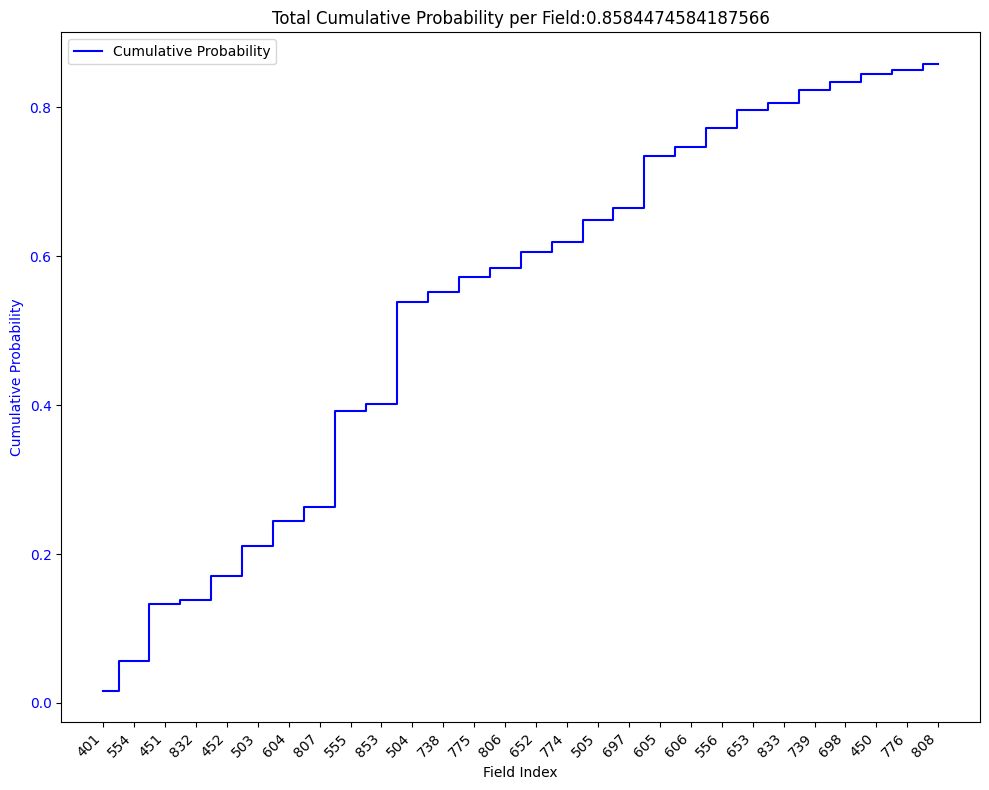

In [24]:
scheduled_fields['cumulative_probability'] = np.cumsum(scheduled_fields['probabilities'])

total_cum_prob = scheduled_fields['cumulative_probability'][-1]

field_indices = np.arange(len(scheduled_fields))  
field_ids = scheduled_fields['field_id'].astype(str) 
cumulative_prob = scheduled_fields['cumulative_probability'] 

fig, ax1 = plt.subplots(figsize=(10, 8))

ax1.step(field_indices, cumulative_prob, where='mid', color='blue', label='Cumulative Probability')
ax1.set_xlabel('Field Index')
ax1.set_ylabel('Cumulative Probability', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax1.set_xticks(field_indices)
ax1.set_xticklabels(field_ids, rotation=45, ha='right')

ax1.legend(loc='upper left')

plt.title(f'Total Cumulative Probability per Field:{total_cum_prob}')
plt.tight_layout()
plt.savefig('cumulative_prob_time_plot_w_05.png', dpi=300)
plt.show()